# Visual

## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import yaml


# import custom functions
from utils import load_zipped_pickle, save_zipped_pickle

## Load Data

In [2]:
test_data = load_zipped_pickle(os.path.join("./Data/", "test.pkl"))

In [8]:
# 从保存的数据中加载预测结果
pred_data_unet_bilinear = load_zipped_pickle(os.path.join("Prediction", "UNet_4_4_bilinear.pkl"))
# pred_data_unet_conv = load_zipped_pickle(os.path.join("Prediction", "UNet_4_4_transpose_conv.pkl"))
pred_data_unet_nested = load_zipped_pickle(os.path.join("Prediction", "Nested_UNet_4_4.pkl"))

## 可视化

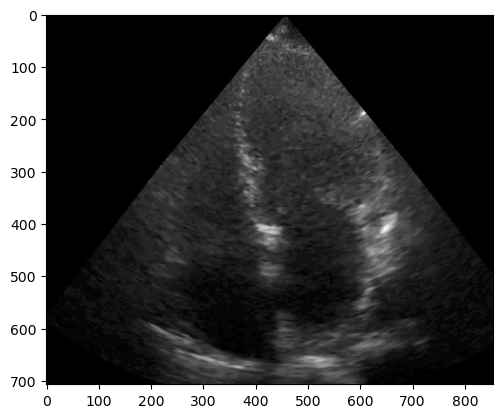

In [144]:
test_img = test_data[video_i]["video"][:, :, 0]
plt.imshow(test_img, cmap="gray")
plt.show()

In [ ]:
box_args = [
    [150, 400, 350, 630], 
    [150, 400, 350, 630], 
    [250, 450, 250, 530], 
    [300, 550, 300, 650], 
    [250, 480, 370, 650], 
    [180, 400, 350, 570], 
    [250, 450, 350, 600], 
    [150, 450, 350, 620], 
    [320, 550, 420, 700], 
    [100, 300, 400, 650], 
    [230, 450, 250, 550], 
    [230, 450, 300, 570], 
    [200, 400, 250, 500], 
    [100, 400, 400, 650], 
    [250, 500, 350, 700], 
    [250, 550, 420, 800], 
    [170, 400, 300, 600], 
    [250, 450, 250, 550], 
    [200, 450, 320, 630], 
    [130, 370, 400, 650], 
]

video_i = 19

test_img = (pred_data_unet_bilinear[video_i]["prediction"][:, :, 5] * 256).astype(np.int16)
box_arg = box_args[video_i]
box = np.zeros_like(test_img)
box[box_arg[0]:box_arg[1], box_arg[2]:box_arg[3]] = 256

fig, ax = plt.subplots()
img = plt.imshow(test_img, cmap="gray", animated=True)
box_img = plt.imshow(box, cmap="Reds", alpha=0.5)

def updatefig(i):
    img.set_array((pred_data_unet_bilinear[video_i]["prediction"][:, :, i] * 256).astype(np.int16))
    box_img.set_array(box)
    return img, box_img

ani = FuncAnimation(fig, updatefig, frames=range(pred_data_unet_bilinear[video_i]["prediction"].shape[2]), blit=True)

HTML(ani.to_jshtml())

In [9]:
# 将预测结果转为灰度图（一个视频一张图）
row_width = 6

new_imgs = []
box_imgs = []
for video in pred_data_unet_nested:
    video = (video["prediction"] * 256).astype(np.int16)
    video = video.transpose(2, 0, 1)
    new_img = []
    box_img = []
    for i in range(0, video.shape[0], row_width):
        box = np.zeros_like(video[i])
        box[box_args[0][0]:box_args[0][1], box_args[0][2]:box_args[0][3]] = 256
        row_box = np.concatenate([box for x in video[i:i + row_width]], axis=1)
        row_img = np.concatenate([x for x in video[i:i + row_width]], axis=1)
        new_img.append(row_img)
        new_img.append((np.ones((5, row_img.shape[1])) * 256).astype(np.int16)) # 增加分割线
    new_img.pop(-1) # 去掉最后一行的分割线
    if len(new_img) > 1 and new_img[-1].shape[1] != new_img[0].shape[1]:
        new_img[-1] = np.pad(new_img[-1], ((0, 0), (0, new_img[0].shape[1] - new_img[-1].shape[1])), mode="constant", constant_values=0)
    new_img = np.concatenate(new_img, axis=0)
    new_imgs.append(new_img)
    

In [12]:
test_array = new_imgs[0]
test_array = (test_array > (256 * 0.1)) * test_array

img = Image.fromarray(test_array)
img = img.convert("L")
img.save("test.png")

In [ ]:
def show_img(img: np.ndarray):
    plt.imshow(img, aspect="auto", cmap="gray")
    plt.show()